# CIFAR10 VAE Example

This notebook demonstrates training a Variational Autoencoder on the CIFAR10 dataset and visualizing the results.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [2]:
# Define the VAE model for CIFAR10
class CIFAR10VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(CIFAR10VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [3]:
# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
# Initialize model and optimizer
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

model = CIFAR10VAE(latent_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device:  mps


In [5]:
# Training function
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Compute loss
        reconstruction_loss = F.mse_loss(recon_batch, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + kl_loss
        
        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'\rTrain Epoch: [{batch_idx}/{len(train_loader)}]\tLoss: {loss.item()/len(data):.6f}', end='')
    
    return train_loss / len(train_loader.dataset)

In [6]:
# Training loop
num_epochs = 20

train_losses = []  # Keep track of losses across epochs

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    print(f'\n====> Epoch: {epoch} Average loss: {train_loss:.4f}')

Train Epoch: [300/391]	Loss: 115.525955
====> Epoch: 1 Average loss: 137.0973
Train Epoch: [300/391]	Loss: 101.753372
====> Epoch: 2 Average loss: 105.8887
Train Epoch: [300/391]	Loss: 91.2977913
====> Epoch: 3 Average loss: 96.1034
Train Epoch: [300/391]	Loss: 89.121918
====> Epoch: 4 Average loss: 89.6013
Train Epoch: [300/391]	Loss: 86.111008
====> Epoch: 5 Average loss: 86.1471
Train Epoch: [300/391]	Loss: 79.931427
====> Epoch: 6 Average loss: 83.6366
Train Epoch: [300/391]	Loss: 79.269089
====> Epoch: 7 Average loss: 82.6869
Train Epoch: [300/391]	Loss: 81.918976
====> Epoch: 8 Average loss: 81.9253
Train Epoch: [300/391]	Loss: 79.318138
====> Epoch: 9 Average loss: 81.1628
Train Epoch: [300/391]	Loss: 79.883446
====> Epoch: 10 Average loss: 80.4214
Train Epoch: [300/391]	Loss: 78.357498
====> Epoch: 11 Average loss: 79.7935
Train Epoch: [300/391]	Loss: 77.451401
====> Epoch: 12 Average loss: 79.5372
Train Epoch: [300/391]	Loss: 81.230751
====> Epoch: 13 Average loss: 79.1829
Tra

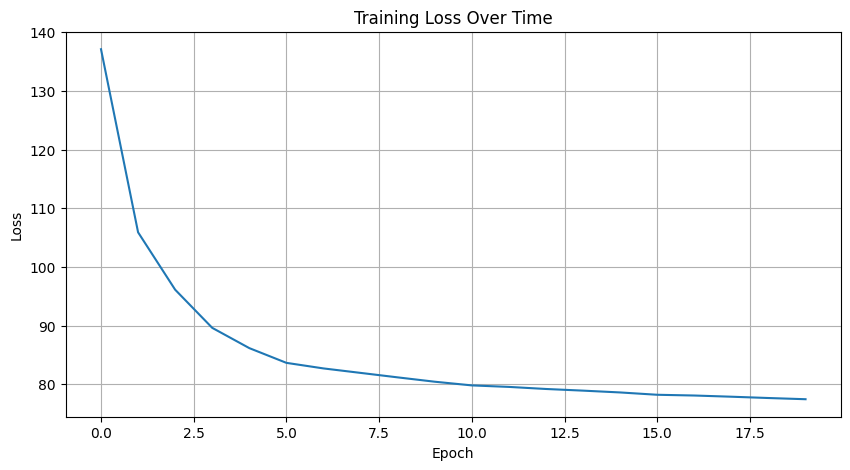

In [7]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [8]:
# Visualization function
def show_images(original, reconstructed, num_images=8):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        
        # Reconstructed images
        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

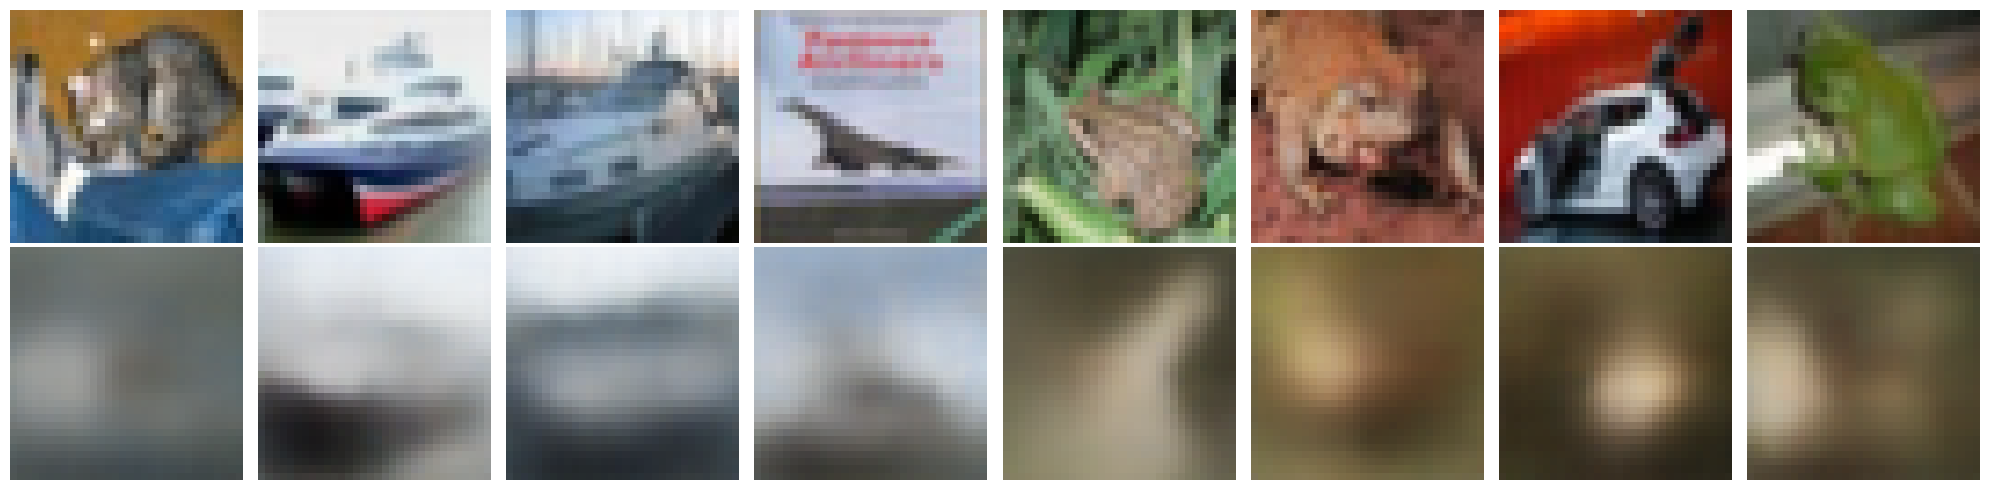

In [9]:
# Get some test images and show reconstructions
model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    
    # Get reconstructions
    reconstructed_images, _, _ = model(test_images)
    
    # Show the first 8 images
    show_images(test_images, reconstructed_images, num_images=8)